<img src = "https://d3njjcbhbojbot.cloudfront.net/api/utilities/v1/imageproxy/https://d15cw65ipctsrr.cloudfront.net/ed/4131809fe511e8937a7926bc59e37f/Professional-Certificate---Data-Science---600x600---Blu-Text.png?auto=format%2Ccompress&dpr=1&w=150&h=150&fit=fill&bg=FFF" width = 100>

<h1 align=center><font size = 5>Comparison of 3 Medium Size French cities profiles</font></h1>

## Introduction

In March 2017, the population of France officially reached 67,000,000 people. As in many countries in the world in the last decades, French population has tended to densify around a limited set of big cities which, as a consequence, concentrate the highest level of economic activities of the country. <br>
It appears clearly that Paris is, by far, the densest area of the French territory (representing up to 19% of the French population) followed by Lyon and Marseille respectively in second and third position. With a population of approximately 1 Million inhabitants, metropolitan areas from the 4th to the 10th rank can all be considered, at the French scale, as illustrations of mid-size cities.<br>
For French people specificities of Paris, Lyon and Marseille are often well known. This is due to the fact that those cities get strong national focus thanks to news, cinema, national sport events (i.e. Soccer) or even lessons provided during history / geography class at school.
Mid-size cities get a lower attention and French people would probably have more difficulties to underline differences or similarities between cities like Toulouse or Nantes for example.<br>
As we did with New York and Toronto, my idea is to perform data exploration of a set of French midsize cities and to determine whether the resulting segmentation and clustering reflects some similarities or specificities. 
Data exploration will be performed for the cities of Toulouse, Bordeaux and Nantes. Apart from the size criteria, selection of those cities is also correlated to the availability of proper location datasets on open platforms (details provided in the next chapter). As a complement to venues data already tested in the labs, exploration will embed economic data (i.e. houses prices).<br>
Studies will be limited to the administrative limits of the cities: suburbs will not be taken into account. 



## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 18px">

<font size = 3>

1. <a href="#item1">collecting French National Houses Prices thanks to Open Data</a><br>
 
2. <a href="#item2">Collecting list of French Addresses thanks to Open Data</a><br>

3. <a href="#item3"> Merging Addresses (lat / long) with Houses Prices</a><br>

4. <a href="#item4">Collecting FOURSQUARE Venues for Each City</a><br>

5. <a href="#item5">Clustering</a><br>
    
6. <a href="#item6">Discussion</a><br>
    
7. <a href="#item7">Conclusion</a><br>
    
    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

In [67]:
!pip install wget
import wget

# 1. Collecting French National Houses Prices thanks to Open Data<a class="anchor" id="item1"></a>

Thanks to an open data platform managed by french government, nation wide houses sell prices for 2018 are freely available at : https://www.data.gouv.fr

In [84]:
## Getting access to list of houses sold in 2018 with addresses and prices
print('2018 French Houses Prices --> Beginning file download with wget module')

url = 'https://www.data.gouv.fr/fr/datasets/r/1be77ca5-dc1b-4e50-af2b-0240147e0346'
wget.download(url, 'houses_data.csv')

2018 French Houses Prices --> Beginning file download with wget module


'houses_data.csv'

From the same platform,  database containing lat, long coordinates of 16 Millions French streets is accessible
Data is stored by French "Department" (French territory is divided in a set of administrative departments
Toulouse is part of "31"
Bordeaux is part of "33"
Nantes is part of "44"

In [ ]:
## Department 31 - Toulouse
!wget -O 31_streets.csv http://bano.openstreetmap.fr/data/bano-31.csv
## Department 33 - Bordeaux
!wget -O 33_streets.csv http://bano.openstreetmap.fr/data/bano-33.csv
## Department 44 - Nantes
!wget -O 44_streets.csv http://bano.openstreetmap.fr/data/bano-44.csv    

In [ ]:
import pandas as pd
## Loading data into a Pandas DF
houses_data = pd.read_csv('houses_data.csv', sep='|')

## 1.1 Houses Prices Data Preparation <a class="anchor" id="item1_1"></a>

In this section we will build 3 distinct data sets (one for each city) with the objective of getting at the end, average houses prices per streets

It appears that some information of the data frame is useless : a lot of columns can be suppressed

In [2]:
### Dropping columns with unrelevant data for the project
houses_data=houses_data[["Valeur fonciere", "Voie","Code postal","Commune","Surface reelle bati"]]

In [3]:
## Building Data sets for each city
Toulouse_houses = houses_data[houses_data["Commune"]=="TOULOUSE"]
Bordeaux_houses = houses_data[houses_data["Commune"]=="BORDEAUX"]
Nantes_houses = houses_data[houses_data["Commune"]=="NANTES"]

In [4]:
Toulouse_houses.head()

Valeur fonciere                      Voie  Code postal   Commune  \
578934       111258,00  MAURICE BOURGES-MAUNOURY      31200.0  TOULOUSE   
578935       111258,00  MAURICE BOURGES-MAUNOURY      31200.0  TOULOUSE   
578936       195000,00                    DURAND      31200.0  TOULOUSE   
578937       195000,00                    DURAND      31200.0  TOULOUSE   
578938        81276,00  MAURICE BOURGES-MAUNOURY      31200.0  TOULOUSE   

        Surface reelle bati  
578934                  0.0  
578935                 79.0  
578936                 58.0  
578937                  0.0  
578938                  0.0

Setting a Function to clean data : drop Na, Deleting records where surface = 0, calculating average houses price for each street

In [4]:
def Houses_data_clean(df):
    # Dropping NaN
    df=df.dropna()
    ## Removing records where surface is = 0
    df=df[df["Surface reelle bati"] != 0]
    ## Converting Houses Prices (Valeur fonciere) to float
    df['Valeur fonciere']=df['Valeur fonciere'].replace(',','.', regex=True).astype(float)
    ## Creating new columns showing price / m2 
    df["Price_m2"] = df["Valeur fonciere"] / df["Surface reelle bati"]
    ## Average Houses Price per Street (Voie) Calculation
    df = df.groupby(['Voie', 'Commune'])["Price_m2"].mean().reset_index()
    ## Returning a quite simple DF with Street, City and Average Price per m2
    return(df)

Cleaning Data and creating an additional column : Average price per squared m

In [5]:
Toulouse_houses = Houses_data_clean(Toulouse_houses)
Nantes_houses = Houses_data_clean(Nantes_houses)
Bordeaux_houses = Houses_data_clean(Bordeaux_houses)

In [8]:
Nantes_houses.head()

Voie Commune      Price_m2
0   A BARBE TORTE  NANTES   3728.560426
1  ABBE DE L EPEE  NANTES  29381.947131
2      ABEL GANCE  NANTES   2449.345100
3  ADOLPHE MOITIE  NANTES   3770.275922
4         AGUESSE  NANTES   5289.855072

Price per m2 superior to 10000 Eur are fake values as no one would pay 200kEur for a single squared meter in Toulouse !
Let's remove values above 10000 Eur/m2

In [6]:
Toulouse_houses=Toulouse_houses[Toulouse_houses["Price_m2"] <= 10000]

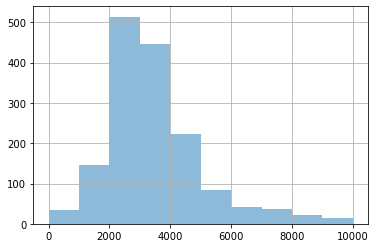

In [58]:
Toulouse_houses["Price_m2"].hist(bins=10, alpha=0.5)

OK That's looks good.

In [59]:
Nantes_houses["Price_m2"].describe()

count      1439.000000
mean       4624.314418
std        8901.046995
min           0.002183
25%        2668.829592
50%        3254.589847
75%        4033.305077
max      163583.333333
Name: Price_m2, dtype: float64

As for Toulouse, Prices per m2 superior to 10000 Eur are fake values as no one would pay for that for a single squared meter in Nantes !
Let's remove values above 10000 Eur/m2

In [7]:
Nantes_houses=Nantes_houses[Nantes_houses["Price_m2"] <= 10000]

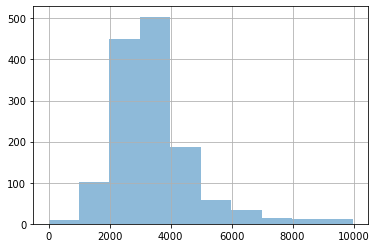

In [61]:
Nantes_houses["Price_m2"].hist(bins=10, alpha=0.5)

In [28]:
Bordeaux_houses["Price_m2"].describe()

count      1119.000000
mean       7411.815597
std       16816.618090
min           0.000805
25%        3933.464036
50%        4945.422266
75%        6460.066175
max      440653.488501
Name: Price_m2, dtype: float64

Bordeaux appears to be a more expensive city compared to the 2 other. 
This time, let's remove values above 20000 Eur/m2

In [8]:
Bordeaux_houses=Bordeaux_houses[Bordeaux_houses["Price_m2"] <= 20000]

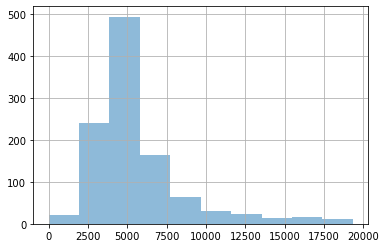

In [63]:
Bordeaux_houses["Price_m2"].hist(bins=10, alpha=0.5)

Defining a Function which will be used to segment houses prices compared to Median Prices

In [9]:
def Houses_Prices_seg (df):
    ## Median Price calculation
    df_median = df["Price_m2"].median()
    print('Median Prices : ', df_median)
    ## Segmenting city prices in 6 categories : Low, Medium Low, Medium, Medium High and High
    df["Houses_L"] = df["Price_m2"] <= (0.4 * df_median)
    df["Houses_ML"] = (df["Price_m2"] > (0.4 * df_median)) & (df["Price_m2"] <= (0.8 * df_median))
    df["Houses_M"] = (df["Price_m2"] > (0.8 * df_median)) & (df["Price_m2"] <= (1.2 * df_median))
    df["Houses_MH"] = (df["Price_m2"] > (1.2 * df_median)) & (df["Price_m2"] <= (1.8 * df_median))
    df["Houses_H"] = (df["Price_m2"] > (1.8 * df_median))
    ## Converting result to float
    df["Houses_L"] = df["Houses_L"].astype(float)
    df["Houses_ML"] = df["Houses_ML"].astype(float)
    df["Houses_M"] = df["Houses_M"].astype(float)
    df["Houses_MH"] = df["Houses_MH"].astype(float)
    df["Houses_H"] = df["Houses_H"].astype(float)
    
    return(df)
    

Bordeaux, is by far more expensive than the 2 other cities. In order to perform homogeneous comparison between those cities, we need to classify houses prices in categories defined according to local median prices : Low, Medium Low, Medium, Medium High, High
Low <= 0.4 * Median / ML 0.4 to 0.8 * Median / Medium 0.8 to 1.2 / Medium High 1.2 to 1.8 / High above 1.8

In [10]:
Toulouse_houses = Houses_Prices_seg(Toulouse_houses)
Nantes_houses = Houses_Prices_seg(Nantes_houses)
Bordeaux_houses = Houses_Prices_seg(Bordeaux_houses)

Median Prices :  3185.294117647059
Median Prices :  3216.1356278520457
Median Prices :  4835.144927536232


Checking Final Data Frame structure (example given for one city)

In [66]:
Bordeaux_houses.head()

Voie   Commune      Price_m2  Houses_L  Houses_ML  Houses_M  \
1              ACHARD  BORDEAUX   8299.734327       0.0        0.0       0.0   
2  ADRIEN BAYSSELANCE  BORDEAUX   7509.405597       0.0        0.0       0.0   
3                AGEN  BORDEAUX   3980.925068       0.0        0.0       1.0   
4              ALBERT  BORDEAUX   3680.622151       0.0        1.0       0.0   
5          ALBERT 1ER  BORDEAUX  12545.375075       0.0        0.0       0.0   

   Houses_MH  Houses_H  
1        1.0       0.0  
2        1.0       0.0  
3        0.0       0.0  
4        0.0       0.0  
5        0.0       1.0

This looks fine, we can then perform the next Step !

# 2. Collecting list of French Adresses thanks to Open Data <a class="anchor" id="item2"></a>

In [ ]:
import pandas as pd
import unicodedata
!pip install Unidecode
from unidecode import unidecode

In [12]:
## French Department data uplaod to dataframe
data_31 = pd.read_csv('31_streets.csv', sep=',', encoding='utf-8')
data_33 = pd.read_csv('33_streets.csv', sep=',', encoding='utf-8')
data_44 = pd.read_csv('44_streets.csv', sep=',', encoding='utf-8')

It appears that some information of the data frame is useless : some columns can be suppressed
It also appears that column heads aren't properly named so let's affect an explicit name to them.
Dropping Duplicates - in order to simplify our approach, Streets numbers weren't taken into account.
As a consequence, duplicate addresses will be removed from DF to keep a single couple of lat / long par street names.

In [13]:
## Defining a Function to Clean Department Data
def clean_dept_data(df, city_name):
    ## Converting Address and City columns to Upper scale
    df["City"]=df["City"].str.upper()
    df["Address"]=df["Address"].str.upper()
    ## Suppressing Accents (French)
    df["Address"]=df['Address'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    ## Dropping NaN
    df=df.dropna()
    ## Keeping only data related to the City
    df=df[df["City"]==city_name].reset_index(drop=True)
    ## Dropping Duplicates
    df.drop_duplicates(subset='Address', keep='first', inplace=True)
    df.reset_index(drop=True, inplace = True)
    
    return(df)

Cleaning location data collected for the 3 cities

In [14]:
### TOULOUSE - Dropping columns with unrelevant data for the project
data_31=data_31[["Chemin des Acacias Vc 13", "31230", "Agassac", "43.371259", "0.889303"]]
data_31=data_31.rename(columns = {"Chemin des Acacias Vc 13" : "Address", "31230" : "Zip_Code", "Agassac" : "City", "43.371259" : "Latitude", "0.889303" : "Longitude"})

## Cleaning Data
toulouse_streets=clean_dept_data(data_31, "TOULOUSE")

In [15]:
### BORDEAUX - Dropping columns with unrelevant data for the project
data_33=data_33[["Rue Avitiacus", "33230", "Abzac", "45.014508", "-0.126840"]]
data_33=data_33.rename(columns = {"Rue Avitiacus" : "Address", "33230" : "Zip_Code", "Abzac" : "City", "45.014508" : "Latitude", "-0.126840" : "Longitude"})

## Cleaning Data
bordeaux_streets=clean_dept_data(data_33, "BORDEAUX")

In [16]:
### NANTES - Dropping columns with unrelevant data for the project
data_44=data_44[["Impasse de la Barre", "44170", "Abbaretz", "47.553330", "-1.530346"]]
data_44=data_44.rename(columns = {"Impasse de la Barre" : "Address", "44170" : "Zip_Code", "Abbaretz" : "City", "47.553330" : "Latitude", "-1.530346" : "Longitude"})

## Cleaning Data
nantes_streets=clean_dept_data(data_44, "NANTES")

# 3. Merging Addresses (lat / long) with Houses Prices <a class="anchor" id="item3"></a>

In this section we will merge data recorded in the Houses Prices data frames with the one stored in addresses dataframe so we can get a unique data frame
including house prices, address and corresponding latitude & longitude

In [17]:
import pandas as pd
import numpy as np

Creating a function which will add Lat & Longitude to houses df thanks to data collected from streets df

In [18]:
def houses_lat_long(houses_df, street_df):
    
    ## Importing Numpy Library
    import numpy as np
    
    ## Adding New Latitude / Longitude Columns to houses df
    houses_df["Latitude"] = np.nan
    houses_df["Longitude"] = np.nan
    
    for ind in houses_df.index:
        houses_test = houses_df['Voie'][ind]
        ## Trying to find street name in Street Dataframe
        street_ind = street_df['Address'][street_df['Address'].str.find(houses_test) != -1]
        ## Checking if street_ind is not empty
        if not street_ind.empty:
            ## Assigning Latitude / Longitude collected from streets DF to houses DF
            houses_df['Latitude'][ind] = street_df.iloc[street_ind.index[0]]['Latitude']
            houses_df['Longitude'][ind] = street_df.iloc[street_ind.index[0]]['Longitude']
    
    ## Dropping NaN values
    houses_df.dropna(inplace=True)
    return()

In [ ]:
## Applying transformation to all cities
houses_lat_long(Toulouse_houses,toulouse_streets)
houses_lat_long(Nantes_houses,nantes_streets)
houses_lat_long(Bordeaux_houses,bordeaux_streets)


In [43]:
Nantes_houses.head()

Voie Commune     Price_m2  Houses_L  Houses_ML  Houses_M  \
2      ABEL GANCE  NANTES  2449.345100       0.0        1.0       0.0   
3  ADOLPHE MOITIE  NANTES  3770.275922       0.0        0.0       1.0   
4         AGUESSE  NANTES  5289.855072       0.0        0.0       0.0   
5      AINO AALTO  NANTES  2985.507680       0.0        0.0       1.0   
6     ALAIN COLAS  NANTES  3564.157706       0.0        0.0       1.0   

   Houses_MH  Houses_H   Latitude  Longitude  
2        0.0       0.0  47.247670  -1.532205  
3        0.0       0.0  47.222162  -1.555209  
4        1.0       0.0  47.212044  -1.598330  
5        0.0       0.0  47.241994  -1.509593  
6        0.0       0.0  47.210472  -1.527245

Good ! Now, for each city,  we have a file with segmented houses price per street + corresponding lat / long. Let's go to  the next step !

## 3.1. Preparing environment for Houses Prices Visualization <a class="anchor" id="item3_1"></a>

Let's visualize Prices on a map of the city. First, let's define a function to simplify plots

In [ ]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

In [169]:
def city_plot(city_name, df, zoom_level=12):
    
    ## Defining a color dictionnary
    df_color = df["Houses_L"] + df["Houses_ML"] * 2 + df["Houses_M"]*3 + df["Houses_MH"]*4 +df["Houses_H"]*5
    color_dict = {1.0:'blue', 2.0:'yellow', 3.0:'orange', 4.0:'red', 5.0:'black'}
    
    ## First, create a geolocator object
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(city_name)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of the City are {}, {}.'.format(latitude, longitude))
    
   
    # create map of the city using latitude and longitude values
    map_city = folium.Map(location=[latitude, longitude], zoom_start=zoom_level)
    
    # add markers to map
    for lat, lng, street, price in zip(df['Latitude'], df['Longitude'], df['Voie'], df_color):
        label = '{},{}'.format(street, price)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=color_dict[price],
            fill=True,
            fill_color=color_dict[price],
            fill_opacity=0.5,
            parse_html=False).add_to(map_city)
 
    display(map_city)
    return
    

Thanks to those new data, I used the Folium library to visualize how house prices are distributed on the cities maps. I applied a color dictionary to distinguish belongings to house prices categories: Blue for Low, yellow for Medium Low, Orange for Medium, Red for Medium High and Black for High. 

## 3.2. Plotting Houses Prices for the City of Toulouse <a class="anchor" id="item3_2"></a>

In [170]:
city_plot("Toulouse", Toulouse_houses, zoom_level=12)

The geograpical coordinate of the City are 43.6044622, 1.4442469.


## 3.3. Plotting Houses Prices for the City of Nantes <a class="anchor" id="item3_3"></a>

In [172]:
city_plot("Nantes", Nantes_houses, zoom_level=12)

The geograpical coordinate of the City are 47.2186371, -1.5541362.


## 3.4. Plotting Houses Prices for the City of Bordeaux <a class="anchor" id="item3_4"></a>

In [174]:
city_plot("Bordeaux", Bordeaux_houses, zoom_level=12)

The geograpical coordinate of the City are 44.841225, -0.5800364.


# 4. Collecting FOURSQUARE Venues for each City <a class="anchor" id="item4"></a>

#### Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = '---' # your Foursquare ID - Note hidden credentials
CLIENT_SECRET = '---' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [20]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files

In [ ]:
## Resetting Indexes
Toulouse_houses.reset_index(drop=True)
Nantes_houses.reset_index(drop=True)
Bordeaux_houses.reset_index(drop=True)

## 4.1. Foursquare API Call Function

Let's reuse the function defined during the Labs

<a id='item2'></a>

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 20):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
import time


In order to limit number of Requests to Foursquare API, data will be segmented into groups of 100 values

In [31]:
## This function segments Houses Dataframe in "s" rows and then calls the Foursquare API
def Foursquare_seg(df, city):
    
    import time
    
    ## Initialisations
    S=50
    N = int(len(df)/S)
    frames = [ df.iloc[i*S:(i+1)*S].copy() for i in range(N+1) ]
    
    for n in range(N):
        print(n)
        nom = frames[n]['Voie']
        lati = frames[n]['Latitude']
        longi = frames[n]['Longitude']
        ## Getting Venues for Toulouse
        df_venues = getNearbyVenues(names=nom,
                                   latitudes=lati,
                                   longitudes=longi
                                  )
        
        ## Writting Result to file
        df_venues.to_csv(r'_'+city+'_venues_0'+str(n)+'.csv')
        
        ## Assigning venues to a global df
        if n ==0:
            res_df_venues = df_venues
        else:
            res_df_venues= res_df_venues.append(df_venues, ignore_index = True)
        
        # Wait for 5 seconds
        time.sleep(5)
        print('====== WAIT 5 SEC =======')
        
    return(res_df_venues)


## 4.2. Getting Venues for Nantes

In [ ]:
nantes_venues= Foursquare_seg(Nantes_houses,'Nantes')

In [48]:
## Cheking Head of dataframe
print(nantes_venues.shape)
nantes_venues.head()

(9141, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      ABEL GANCE              47.247670               -1.532205   
1      ABEL GANCE              47.247670               -1.532205   
2      ABEL GANCE              47.247670               -1.532205   
3      ABEL GANCE              47.247670               -1.532205   
4  ADOLPHE MOITIE              47.222162               -1.555209   

                Venue  Venue Latitude  Venue Longitude     Venue Category  
0   Intermarché Hyper       47.244689        -1.534589      Shopping Mall  
1     Stade Don Bosco       47.244777        -1.535660     Soccer Stadium  
2     Le Camion Rouge       47.244538        -1.535600         Food Truck  
3    Le Café Gourmand       47.243898        -1.535785  French Restaurant  
4  Marché de Talensac       47.221351        -1.557709     Farmers Market

In [33]:
## Saving venues to a global file
nantes_venues.to_csv(r'_nantes_venues_2019109.csv')

## 4.3. Getting Venues for Toulouse

In [ ]:
toulouse_venues= Foursquare_seg(Toulouse_houses,'Toulouse')

In [49]:
## Cheking Head of dataframe
print(toulouse_venues.shape)
toulouse_venues.head()

(9615, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         ABADIE              43.585215                1.408049   
1         ABADIE              43.585215                1.408049   
2         ABADIE              43.585215                1.408049   
3  ABEL AUTEFAGE              43.595222                1.454582   
4  ABEL AUTEFAGE              43.595222                1.454582   

                         Venue  Venue Latitude  Venue Longitude  \
0           Casino supermarché       43.584234         1.405252   
1         Hotel Akena le Prado       43.588768         1.410594   
2                       SPEEDY       43.588390         1.412103   
3         Jardin du Grand Rond       43.595987         1.452373   
4  Kiosque du Grand Rond - Mio       43.596858         1.452312   

       Venue Category  
0         Supermarket  
1               Hotel  
2       Auto Workshop  
3              Garden  
4  Chinese Restaurant

In [40]:
## Saving venues to a global file
toulouse_venues.to_csv(r'_toulouse_venues_20191009.csv')

## 4.4. Getting Venues for Bordeaux

In [ ]:
bordeaux_venues= Foursquare_seg(Bordeaux_houses,'Bordeaux')

In [47]:
## Cheking Head of dataframe
print(bordeaux_venues.shape)
bordeaux_venues.head()

(8952, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       ACHARD              44.867948               -0.548273   
1       ACHARD              44.867948               -0.548273   
2       ACHARD              44.867948               -0.548273   
3       ACHARD              44.867948               -0.548273   
4       ACHARD              44.867948               -0.548273   

                  Venue  Venue Latitude  Venue Longitude     Venue Category  
0   Les Vivres de l’Art       44.864193        -0.549372        Art Gallery  
1     Le Garage Moderne       44.865226        -0.550378        Art Gallery  
2                   H36       44.865477        -0.553148  French Restaurant  
3  Station Rue Achard Ⓑ       44.866599        -0.548691       Tram Station  
4      Bar de la Marine       44.865504        -0.548531  French Restaurant

In [44]:
## Saving venues to a global file
bordeaux_venues.to_csv(r'_bordeaux_venues_20191009.csv')

## 4.5. Reading Venues data from csv files (backup)

Reading data from saved csv files (built thanks to Foursquare API), this will avoid long execution times required to get data from Foursquare

In [2]:
import pandas as pd

In [21]:
toulouse_venues=pd.read_csv('_toulouse_venues_20191009.csv')
toulouse_venues=toulouse_venues.rename(columns={'Unnamed: 0': 'City'})
toulouse_venues['City']='TOULOUSE'
toulouse_venues.head()

City   Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  TOULOUSE         ABADIE              43.585215                1.408049   
1  TOULOUSE         ABADIE              43.585215                1.408049   
2  TOULOUSE         ABADIE              43.585215                1.408049   
3  TOULOUSE  ABEL AUTEFAGE              43.595222                1.454582   
4  TOULOUSE  ABEL AUTEFAGE              43.595222                1.454582   

                         Venue  Venue Latitude  Venue Longitude  \
0           Casino supermarché       43.584234         1.405252   
1         Hotel Akena le Prado       43.588768         1.410594   
2                       SPEEDY       43.588390         1.412103   
3         Jardin du Grand Rond       43.595987         1.452373   
4  Kiosque du Grand Rond - Mio       43.596858         1.452312   

       Venue Category  
0         Supermarket  
1               Hotel  
2       Auto Workshop  
3              Garden  
4  Chinese Restaurant

In [22]:
nantes_venues=pd.read_csv('_nantes_venues_20191009.csv')
nantes_venues=nantes_venues.rename(columns={'Unnamed: 0': 'City'})
nantes_venues['City']='NANTES'
nantes_venues.head()

City    Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  NANTES      ABEL GANCE              47.247670               -1.532205   
1  NANTES      ABEL GANCE              47.247670               -1.532205   
2  NANTES      ABEL GANCE              47.247670               -1.532205   
3  NANTES      ABEL GANCE              47.247670               -1.532205   
4  NANTES  ADOLPHE MOITIE              47.222162               -1.555209   

                Venue  Venue Latitude  Venue Longitude     Venue Category  
0   Intermarché Hyper       47.244689        -1.534589      Shopping Mall  
1     Stade Don Bosco       47.244777        -1.535660     Soccer Stadium  
2     Le Camion Rouge       47.244538        -1.535600         Food Truck  
3    Le Café Gourmand       47.243898        -1.535785  French Restaurant  
4  Marché de Talensac       47.221351        -1.557709     Farmers Market

In [23]:
bordeaux_venues=pd.read_csv('_bordeaux_venues_20191009.csv', index_col=False)
bordeaux_venues=bordeaux_venues.rename(columns={'Unnamed: 0': 'City'})
bordeaux_venues['City']='BORDEAUX'
bordeaux_venues.head()

City Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  BORDEAUX       ACHARD              44.867948               -0.548273   
1  BORDEAUX       ACHARD              44.867948               -0.548273   
2  BORDEAUX       ACHARD              44.867948               -0.548273   
3  BORDEAUX       ACHARD              44.867948               -0.548273   
4  BORDEAUX       ACHARD              44.867948               -0.548273   

                  Venue  Venue Latitude  Venue Longitude     Venue Category  
0   Les Vivres de l’Art       44.864193        -0.549372        Art Gallery  
1     Le Garage Moderne       44.865226        -0.550378        Art Gallery  
2                   H36       44.865477        -0.553148  French Restaurant  
3  Station Rue Achard Ⓑ       44.866599        -0.548691       Tram Station  
4      Bar de la Marine       44.865504        -0.548531  French Restaurant

## 4.6. Venues Basic Analysis for each city

Let's check how many venues were returned for Toulouse

In [40]:
toulouse_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                            
ABADIE                               3                       3      3   
ABEL AUTEFAGE                       14                      14     14   
ACHILLE MIR                          3                       3      3   
ACHILLE VIADIEU                     12                      12     12   
ADOLPHE COLL                        11                      11     11   
...                                ...                     ...    ...   
VICTOR HUGO                         20                      20     20   
VICTOR SEGOFFIN                      5                       5      5   
VIGUERIE                            20                      20     20   
VILLAUDRIC                           4                       4      4   
VILLENEUVE                           4                       4      4   

                 Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                      
ABADIE                        3                3               3  
ABEL AUTEFAGE                14               14              14  
ACHILLE MIR                   3                3               3  
ACHILLE VIADIEU              12               12              12  
ADOLPHE COLL                 11               11              11  
...                         ...              ...             ...  
VICTOR HUGO                  20               20              20  
VICTOR SEGOFFIN               5                5               5  
VIGUERIE                     20               20              20  
VILLAUDRIC                    4                4               4  
VILLENEUVE                    4                4               4  

[1335 rows x 6 columns]

Let's find out how many unique categories can be curated from all the returned venues

In [41]:
print('There are {} uniques categories for Toulouse.'.format(len(toulouse_venues['Venue Category'].unique())))

There are 220 uniques categories for Toulouse.


Let's check how many venues were returned for Nantes

In [52]:
nantes_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                           
ABEL GANCE                          4                       4      4   
ADOLPHE MOITIE                     20                      20     20   
AGUESSE                             4                       4      4   
AINO AALTO                          4                       4      4   
ALAIN COLAS                         6                       6      6   
...                               ...                     ...    ...   
TURENNE                            20                      20     20   
VAN ISEGHEM                         4                       4      4   
VAUCANSON                          12                      12     12   
VAUQUELIN                          15                      15     15   
VELASQUEZ                           4                       4      4   

                Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                     
ABEL GANCE                   4                4               4  
ADOLPHE MOITIE              20               20              20  
AGUESSE                      4                4               4  
AINO AALTO                   4                4               4  
ALAIN COLAS                  6                6               6  
...                        ...              ...             ...  
TURENNE                     20               20              20  
VAN ISEGHEM                  4                4               4  
VAUCANSON                   12               12              12  
VAUQUELIN                   15               15              15  
VELASQUEZ                    4                4               4  

[1147 rows x 6 columns]

Let's find out how many unique categories can be curated from all the returned venues

In [45]:
print('There are {} uniques categories for Nantes.'.format(len(nantes_venues['Venue Category'].unique())))

There are 188 uniques categories for Nantes.


Let's check how many venues were returned for Bordeaux

In [54]:
bordeaux_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                               
ACHARD                                 10                      10     10   
ADRIEN BAYSSELANCE                      5                       5      5   
AGEN                                    4                       4      4   
ALBERT                                  4                       4      4   
ALBERT 1ER                              4                       4      4   
...                                   ...                     ...    ...   
THEODORE GARDERE                        6                       6      6   
THERESIA CABARRUS                       4                       4      4   
THIAC                                  20                      20     20   
THIERS                                 10                      10     10   
TIFFONET                               20                      20     20   

                    Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                         
ACHARD                          10               10              10  
ADRIEN BAYSSELANCE               5                5               5  
AGEN                             4                4               4  
ALBERT                           4                4               4  
ALBERT 1ER                       4                4               4  
...                            ...              ...             ...  
THEODORE GARDERE                 6                6               6  
THERESIA CABARRUS                4                4               4  
THIAC                           20               20              20  
THIERS                          10               10              10  
TIFFONET                        20               20              20  

[848 rows x 6 columns]

#### Let's find out how many unique categories can be curated from all the returned venues

In [46]:
print('There are {} uniques categories for Bordeaux.'.format(len(bordeaux_venues['Venue Category'].unique())))

There are 200 uniques categories for Bordeaux.


Creating a Dataframe containing all cities venues. The objective of this approach is to have vectors of similar sizes for each city. At the end, this will allow clusters comparison between the 3 cities taken into consideration for this project.

In [24]:
global_venues=pd.concat([toulouse_venues, nantes_venues, bordeaux_venues])
global_venues.head()

City   Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  TOULOUSE         ABADIE              43.585215                1.408049   
1  TOULOUSE         ABADIE              43.585215                1.408049   
2  TOULOUSE         ABADIE              43.585215                1.408049   
3  TOULOUSE  ABEL AUTEFAGE              43.595222                1.454582   
4  TOULOUSE  ABEL AUTEFAGE              43.595222                1.454582   

                         Venue  Venue Latitude  Venue Longitude  \
0           Casino supermarché       43.584234         1.405252   
1         Hotel Akena le Prado       43.588768         1.410594   
2                       SPEEDY       43.588390         1.412103   
3         Jardin du Grand Rond       43.595987         1.452373   
4  Kiosque du Grand Rond - Mio       43.596858         1.452312   

       Venue Category  
0         Supermarket  
1               Hotel  
2       Auto Workshop  
3              Garden  
4  Chinese Restaurant

Performing One Hot Encoding with this dataframe

In [25]:
from sklearn import preprocessing
  
# one hot encoding
venues_onehot = pd.get_dummies(global_venues[['Venue Category']], prefix="", prefix_sep="")
venues_onehot.head()

# add city column back to dataframe
venues_onehot['City'] = global_venues['City']
venues_onehot['Neighborhood'] = global_venues['Neighborhood']


# move city column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

Splitting this dataframe for the 3 cities

In [26]:
toulouse_onehot=venues_onehot[venues_onehot['City']=='TOULOUSE']
nantes_onehot=venues_onehot[venues_onehot['City']=='NANTES']
bordeaux_onehot=venues_onehot[venues_onehot['City']=='BORDEAUX']

## 4.7. Deeper Exploration of cities

#### 4.7.1. Function Definition

First, let's write a function to sort the venues in descending order.

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

This function is defined to perform deeper exploration of each city. Arguments : df = df containing list of venues for each city

In [29]:
def venues_analysis(df_venues, df_houses):
    
    from sklearn import preprocessing
  
    # one hot encoding
    #df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
    
    # add neighborhood column back to dataframe
    #df_onehot['Neighborhood'] = df_venues['Neighborhood']
    
    # move neighborhood column to the first column
    #fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
    df_onehot = df_venues.drop(['City'], axis=1)
    
    # Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
    df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
    df_houses_tmp = df_houses[['Voie','Houses_L', 'Houses_ML', 'Houses_M', 'Houses_MH', 'Houses_H']].copy()
    df_houses_tmp['Houses_L'] = df_houses_tmp['Houses_L'] / 5
    df_houses_tmp['Houses_ML'] = df_houses_tmp['Houses_ML'] / 5
    df_houses_tmp['Houses_M'] = df_houses_tmp['Houses_M'] / 5
    df_houses_tmp['Houses_MH'] = df_houses_tmp['Houses_MH'] / 5
    df_houses_tmp['Houses_H'] = df_houses_tmp['Houses_H'] / 5
    df_grouped_tmp = df_grouped.join(df_houses_tmp.set_index('Voie'), on='Neighborhood')
    
    #Now let's create the new dataframe and display the top 10 venues for each neighborhood
    num_top_venues = 5
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    df_neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

    for ind in np.arange(df_grouped.shape[0]):
        df_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)
    
    # merge venues data with houses prices data to add latitude/longitude for each neighborhood
    #df_tempo = df_houses.join(df_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Voie')
    df_tempo = df_neighborhoods_venues_sorted.join(df_houses.set_index('Voie'), on='Neighborhood')
    
    # Removing unnecessary df
    df_merged=df_tempo.reset_index(drop=True)

    return df_merged, df_grouped_tmp
    

#### 4.7.2 Dataframes definition for every city

In [30]:
# City of Toulouse
toulouse_merged, toulouse_grouped = venues_analysis(toulouse_onehot, Toulouse_houses)

In [31]:
# City of Nantes
nantes_merged, nantes_grouped = venues_analysis(nantes_onehot, Nantes_houses)

In [32]:
# City of Bordeaux
bordeaux_merged, bordeaux_grouped = venues_analysis(bordeaux_onehot, Bordeaux_houses)

<a id='item3'></a>

<a id='item4'></a>

# 5. Clustering <a class="anchor" id="item5"></a>

Run *k*-means to cluster the neighborhood into clusters.

## 5.1. Defining Functions to perform K-Means for each city

In [33]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

The function below will be used to run Kmeans algortithm multiple times. It returns Silhouette & Inertia scores in order to analyze which value of K (nb of clusters) will be optimum

In [52]:
def city_Kmean(df_grouped, df_merged, clusterMAX = 20):
    
    #sil_score = pd.DataFrame(np.zeros((clusterMAX, 1)))
    score_df = pd.DataFrame(columns = ['Sil', 'Inertia','K_clust'])
    
    ### Building cluster DF - Remove string columns => Neighborhood (Voie)
    df_grouped_clustering = df_grouped.drop('Neighborhood', 1)
    
    for kclusters in range (2,clusterMAX):
        # run k-means clustering
        kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)
        sil_score = silhouette_score(df_grouped_clustering, kmeans.labels_)
        print('Silhouette score : ', sil_score)
        print('Inertia: ', kmeans.inertia_)
        print('Kclusters :',kclusters )
        score_df = score_df.append({'Sil':sil_score, 'Inertia':kmeans.inertia_, 'K_clust': kclusters}, ignore_index=True)
    
    return score_df

Once nb of clusters will be determined, the function below will be called to return a dataframe containing cluster category for each Neighborhodd

In [34]:
def city_Kmean_Neigh(df_grouped, df_merged, kclusters = 10):
    
   
    ### Building cluster DF - Remove string columns => Neighborhood (Voie)
    df_grouped_clustering = df_grouped.drop('Neighborhood', 1)
    df_grouped_tmp = df_grouped
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 
    
    # add clustering labels
    df_grouped_tmp.insert(0, 'Cluster Labels', kmeans.labels_)
    
    # Get centroids position
    df_centroids=kmeans.cluster_centers_
    
    # merge df_grouped with houses prices to add latitude/longitude for each neighborhood
    df_merged_cluster = df_merged.join(df_grouped_tmp[['Neighborhood','Cluster Labels']].set_index('Neighborhood'), on='Neighborhood')
    
    return df_merged_cluster, df_centroids

## 5.2. Clustering for Toulouse

In [ ]:
toulouse_score_df=city_Kmean(toulouse_grouped, toulouse_merged)

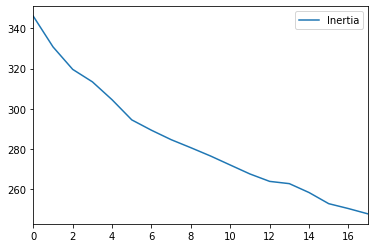

In [56]:
toulouse_score_df.plot(y='Inertia', use_index=True)

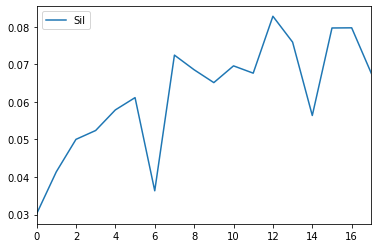

In [58]:
toulouse_score_df.plot(y='Sil', use_index=True)

The optimimum value of K appears to be 12. Let's call K means with this value and build a dataframe containing categories, venues & houses prices

In [35]:
toulouse_merged_cluster, toulouse_centroids = city_Kmean_Neigh (toulouse_grouped, toulouse_merged, kclusters = 12)

## 5.3. Clustering for Nantes

In [ ]:
nantes_score_df=city_Kmean(nantes_grouped, nantes_merged, clusterMAX = 20)

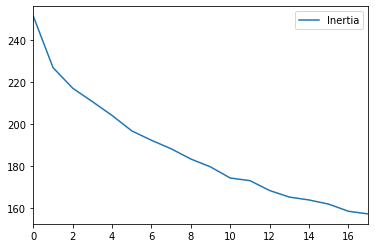

In [128]:
nantes_score_df.plot(y='Inertia', use_index=True)

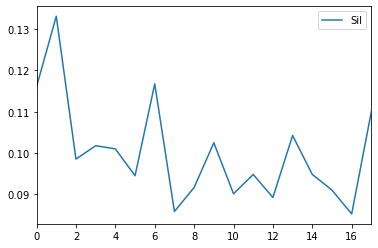

In [129]:
nantes_score_df.plot(y='Sil', use_index=True)

The optimimum value of K appears to be 6. Let's call K means with this value and build a dataframe containing categories, venues & houses prices

In [36]:
nantes_merged_cluster, nantes_centroids = city_Kmean_Neigh (nantes_grouped, nantes_merged, kclusters = 6)

## 5.4. Clustering for Bordeaux

In [ ]:
bordeaux_score_df=city_Kmean(bordeaux_grouped, bordeaux_merged, clusterMAX = 20)

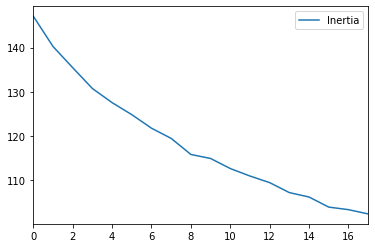

In [40]:
bordeaux_score_df.plot(y='Inertia', use_index=True)

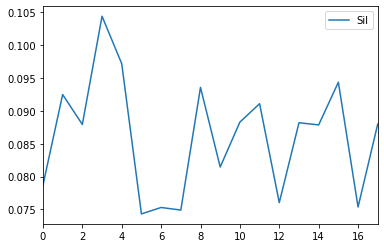

In [41]:
bordeaux_score_df.plot(y='Sil', use_index=True)

The optimimum value of K appears to be 3. Let's call K means with this value and build a dataframe containing categories, venues & houses prices

In [37]:
bordeaux_merged_cluster , bordeaux_centroids = city_Kmean_Neigh (bordeaux_grouped, bordeaux_merged, kclusters = 3)

## 5.5. Examine Clusters

Let's visualize the resulting clusters - Let's build a function for that

In [38]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [62]:
def city_cluster_viz(kclusters, df_merged_cluster, city_name):
    
    ## First, create a geolocator object
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(city_name)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of the City are {}, {}.'.format(latitude, longitude))
    
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_merged_cluster['Latitude'], df_merged_cluster['Longitude'], df_merged_cluster['Neighborhood'], df_merged_cluster['Cluster Labels'].astype(int)):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    
    display(map_clusters)
    return   

#### 5.5.1 Plotting Clusters for Toulouse

In [124]:
city_cluster_viz(12, toulouse_merged_cluster, 'TOULOUSE')

The geograpical coordinate of the City are 43.6044622, 1.4442469.


#### 5.5.2. Plotting Clusters for Nantes

In [125]:
city_cluster_viz(6, nantes_merged_cluster, 'NANTES')

The geograpical coordinate of the City are 47.2186371, -1.5541362.


#### 5.5.3. Plotting Clusters for Bordeaux

In [134]:
city_cluster_viz(3, bordeaux_merged_cluster, 'BORDEAUX')

The geograpical coordinate of the City are 44.841225, -0.5800364.


It appears that the spatial repartition of clusters differs from one city to the other. While we can notice that some clustering areas are quite dense for the cities of Toulouse and Nantes (i.e. dense red area close to the city center of Nantes), repartition of clusters for the city of Bordeaux is closer to a homogeneous distribution of single nodes over the city map.

## 5.6. Identifying Number of streets per city cluster

It seemed interesting to me to determine, for each city, the number of neighborhoods (one neighborhood = one city street) contained in each cluster. This distribution is illustrated by the horizontal bar plots below:

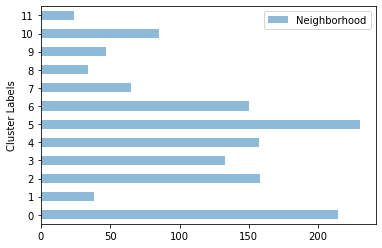

In [148]:
ax = toulouse_merged_cluster.groupby('Cluster Labels').count()[['Neighborhood']].plot.barh(alpha=0.5)

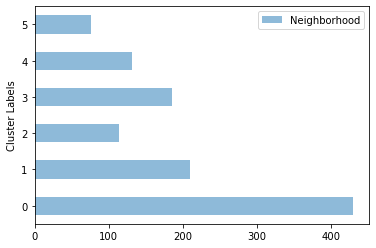

In [147]:
ax = nantes_merged_cluster.groupby('Cluster Labels').count()[['Neighborhood']].plot.barh(alpha=0.5)

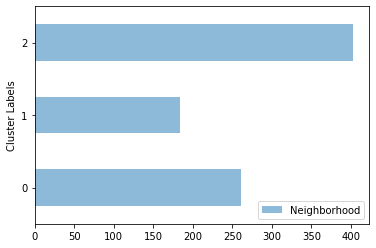

In [149]:
ax =bordeaux_merged_cluster.groupby('Cluster Labels').count()[['Neighborhood']].plot.barh(alpha=0.5)

## 5.7. Comparing City clusters

To compare city clusters between each other, we will measure distance between their centroids. Euclidian distance will be used as a metric. 
For this, we import euclidian distances from sklearn

In [41]:
from sklearn.metrics.pairwise import euclidean_distances

Now let's measure euclidian distance between each city clusters : bordeaux_nantes, bordeaux_toulouse and nantes_toulouse. distances will be stored in a numpy array

In [42]:
dist_bordeaux_nantes=euclidean_distances(bordeaux_centroids, nantes_centroids)
dist_bordeaux_toulouse=euclidean_distances(bordeaux_centroids, toulouse_centroids)
dist_nantes_toulouse=euclidean_distances(nantes_centroids, toulouse_centroids)

Let's use bar plots to visualize inter centroids distances

In [39]:
# First, import Matplotlib
import matplotlib.pyplot as plt

<span style="color:brown">Let's visualize distances between the clusters of Bordeaux and the clusters of Nantes</span>

Text(0.5, 1.0, 'Distance between Cluster 0 of Bordeaux & Clusters of Nantes')

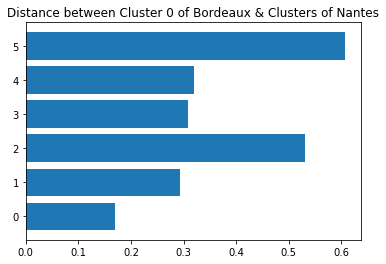

In [105]:
plt.barh(np.arange(len(dist_bordeaux_nantes[0,:])),dist_bordeaux_nantes[0,:])
plt.title('Distance between Cluster 0 of Bordeaux & Clusters of Nantes')

Text(0.5, 1.0, 'Distance between Cluster 1 of Bordeaux & Clusters of Nantes')

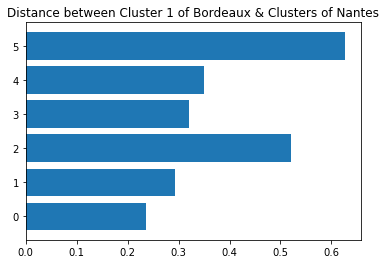

In [106]:
plt.barh(np.arange(len(dist_bordeaux_nantes[1,:])),dist_bordeaux_nantes[1,:])
plt.title('Distance between Cluster 1 of Bordeaux & Clusters of Nantes')

Text(0.5, 1.0, 'Distance between Cluster 2 of Bordeaux & Clusters of Nantes')

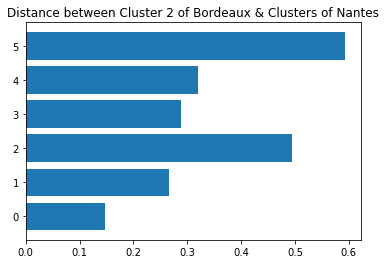

In [107]:
plt.barh(np.arange(len(dist_bordeaux_nantes[2,:])),dist_bordeaux_nantes[2,:])
plt.title('Distance between Cluster 2 of Bordeaux & Clusters of Nantes')

<span style="color:brown">Let's visualize distances between the clusters of Bordeaux and the clusters of Toulouse</span>

Text(0.5, 1.0, 'Distance between Cluster 0 of Bordeaux & Clusters of Toulouse')

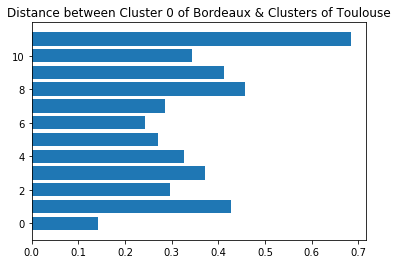

In [110]:
plt.barh(np.arange(len(dist_bordeaux_toulouse[0,:])),dist_bordeaux_toulouse[0,:])
plt.title('Distance between Cluster 0 of Bordeaux & Clusters of Toulouse')

Text(0.5, 1.0, 'Distance between Cluster 1 of Bordeaux & Clusters of Toulouse')

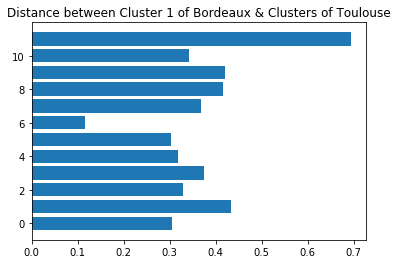

In [112]:
plt.barh(np.arange(len(dist_bordeaux_toulouse[1,:])),dist_bordeaux_toulouse[1,:])
plt.title('Distance between Cluster 1 of Bordeaux & Clusters of Toulouse')

Text(0.5, 1.0, 'Distance between Cluster 2 of Bordeaux & Clusters of Toulouse')

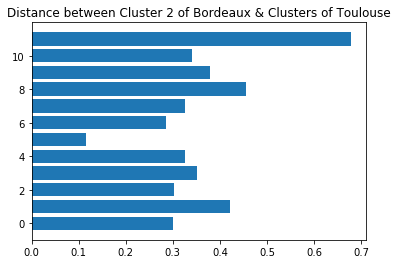

In [123]:
plt.barh(np.arange(len(dist_bordeaux_toulouse[2,:])),dist_bordeaux_toulouse[2,:])
plt.title('Distance between Cluster 2 of Bordeaux & Clusters of Toulouse')

<span style="color:brown">Let's visualize distances between the clusters of Nantes and the clusters of Toulouse</span>

Text(0.5, 1.0, 'Distance between Cluster 0 of Nantes & Clusters of Toulouse')

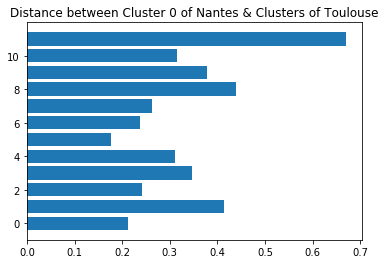

In [117]:
plt.barh(np.arange(len(dist_nantes_toulouse[0,:])),dist_nantes_toulouse[0,:])
plt.title('Distance between Cluster 0 of Nantes & Clusters of Toulouse')

Text(0.5, 1.0, 'Distance between Cluster 1 of Nantes & Clusters of Toulouse')

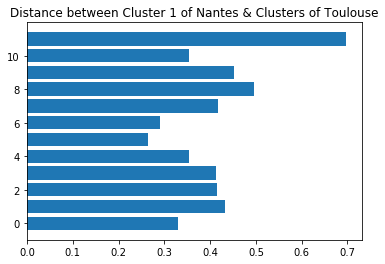

In [118]:
plt.barh(np.arange(len(dist_nantes_toulouse[1,:])),dist_nantes_toulouse[1,:])
plt.title('Distance between Cluster 1 of Nantes & Clusters of Toulouse')

Text(0.5, 1.0, 'Distance between Cluster 2 of Nantes & Clusters of Toulouse')

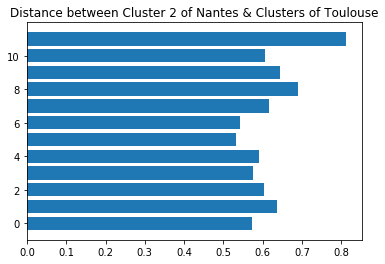

In [119]:
plt.barh(np.arange(len(dist_nantes_toulouse[2,:])),dist_nantes_toulouse[2,:])
plt.title('Distance between Cluster 2 of Nantes & Clusters of Toulouse')

Text(0.5, 1.0, 'Distance between Cluster 3 of Nantes & Clusters of Toulouse')

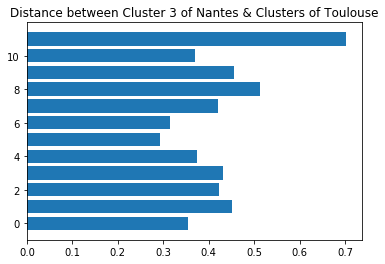

In [124]:
plt.barh(np.arange(len(dist_nantes_toulouse[3,:])),dist_nantes_toulouse[3,:])
plt.title('Distance between Cluster 3 of Nantes & Clusters of Toulouse')

Text(0.5, 1.0, 'Distance between Cluster 4 of Nantes & Clusters of Toulouse')

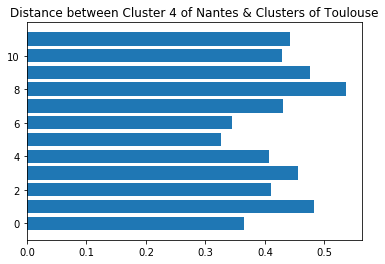

In [121]:
plt.barh(np.arange(len(dist_nantes_toulouse[4,:])),dist_nantes_toulouse[4,:])
plt.title('Distance between Cluster 4 of Nantes & Clusters of Toulouse')

Text(0.5, 1.0, 'Distance between Cluster 5 of Nantes & Clusters of Toulouse')

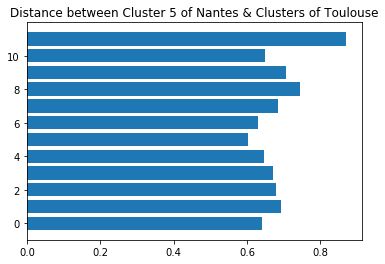

In [122]:
plt.barh(np.arange(len(dist_nantes_toulouse[5,:])),dist_nantes_toulouse[5,:])
plt.title('Distance between Cluster 5 of Nantes & Clusters of Toulouse')

Now let's find minimum distances in order to focus on clusters being the closest to each other

In [43]:
## Bordeaux to Nantes minimum distance
print('Minimum distance between Bordeaux and Nantes', np.amin(dist_bordeaux_nantes))

Minimum distance between Bordeaux and Nantes 0.14710909198356295


In [57]:
print('Index position of the smallest distance: ',np.argmin(dist_bordeaux_nantes))

Index position of the smallest distance:  12


In [65]:
print('Distance between clusters of Bordeaux and Nantes arrays')
print(dist_bordeaux_nantes)

Distance between clusters of Nantes and Bordeaux arrays
[[0.17002824 0.29292572 0.53110303 0.30798524 0.32007478 0.60604286]
 [0.23621138 0.29317079 0.52011049 0.32020786 0.34922881 0.62610063]
 [0.14710909 0.2667333  0.49529797 0.28877924 0.3195258  0.5923125 ]]


Cluster 2 of Bordeaux and Cluster 0 of Nantes are the closest. Note that Clusters 0 of Bordeaux and Nantes are also close to each other

In [51]:
## Bordeaux to Toulouse minimum distance
print('Minimum distance between Bordeaux and Toulouse', np.amin(dist_bordeaux_toulouse))

Minimum distance between Bordeaux and Toulouse 0.11482059061667176


In [58]:
print('Index position of the smallest distance: ',np.argmin(dist_bordeaux_toulouse))

Index position of the smallest distance:  29


In [66]:
print('Distance between clusters of Bordeaux and Toulouse arrays')
print(dist_bordeaux_toulouse)

Distance between clusters of Bordeaux and Toulouse arrays
[[0.14168713 0.42638545 0.29734887 0.37204503 0.32613901 0.27121412
  0.24364566 0.28559836 0.45712473 0.41178741 0.34255309 0.68324224]
 [0.3048055  0.43295936 0.32998458 0.37383596 0.31760542 0.30248239
  0.11668045 0.36828753 0.41568827 0.42081483 0.34304218 0.69323313]
 [0.30057735 0.4212734  0.30344083 0.35077005 0.32496757 0.11482059
  0.28622894 0.3267444  0.45439904 0.3797324  0.34064161 0.67748579]]


Cluster 2 of Bordeaux and Cluster 5 of Toulouse are the closest. Note that cluster 1 of Bordeaux and Cluster 5 of Toulouse are also close to each other

In [60]:
## Nantes to Toulouse minimum distance
print('Minimum distance between Nantes and Toulouse', np.amin(dist_nantes_toulouse))

Minimum distance between Nantes and Toulouse 0.17713934812057577


In [62]:
print('Index position of the smallest distance: ',np.argmin(dist_nantes_toulouse))

Index position of the smallest distance:  5


In [67]:
print('Distance between clusters of Nantes and Toulouse arrays')
print(dist_nantes_toulouse)

Distance between clusters of Nantes and Toulouse arrays
[[0.21221461 0.41391515 0.24245469 0.34618536 0.31034336 0.17713935
  0.23683115 0.26355877 0.43869887 0.37828784 0.31501181 0.66940947]
 [0.33054774 0.43278539 0.41497542 0.4132317  0.35468857 0.26503781
  0.2910292  0.4162905  0.49657387 0.45208336 0.35347569 0.69639062]
 [0.57234348 0.63752819 0.6046826  0.57475678 0.59086221 0.53140151
  0.54136508 0.61722565 0.68940776 0.64427511 0.60585494 0.81168802]
 [0.35445408 0.45189675 0.422665   0.4311263  0.3736848  0.29233363
  0.3157696  0.42011839 0.51304252 0.45661938 0.36944194 0.70190652]
 [0.36477653 0.48310453 0.41087769 0.45511391 0.4069293  0.32698255
  0.34387098 0.42998537 0.53599531 0.47626518 0.42920948 0.44256876]
 [0.64094091 0.69402668 0.67882376 0.67177188 0.64597027 0.60198605
  0.62957575 0.68561387 0.74427264 0.70643217 0.6495357  0.86940617]]


Cluster 0 of Nantes and Cluster 5 of Toulouse are the closest. All other clusters centroids have high distances

Let's analyse content of similar clusters : Bordeaux Cluster 0 and Nantes Cluster 0

In [68]:
## Let's visualize content of Bordeaux cluster 0
bordeaux_merged_cluster.loc[bordeaux_merged_cluster['Cluster Labels'] == 0, bordeaux_merged_cluster.columns[[1] + list(range(2, bordeaux_merged_cluster.shape[1]))]]

1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0                   Plaza      French Restaurant           Art Gallery   
1                     Bar                  Plaza      Sushi Restaurant   
4           Grocery Store  Portuguese Restaurant         Movie Theater   
7                     Pub             Restaurant                  Café   
12         Cosmetics Shop          Train Station          Hockey Arena   
..                    ...                    ...                   ...   
831                 Hotel                   Café                Bakery   
837                   Bar                  Plaza      Asian Restaurant   
838                 Hotel                  Plaza     French Restaurant   
842            Hotel Pool            Coffee Shop         Grocery Store   
845     French Restaurant                  Hotel                 Plaza   

    4th Most Common Venue 5th Most Common Venue   Commune      Price_m2  \
0            Tram Station           Supermarket  BORDEAUX   8299.734327   
1            Tram Station          Bathing Area  BORDEAUX   7509.405597   
4             Fish Market                   Zoo  BORDEAUX  12545.375075   
7      Italian Restaurant      Botanical Garden  BORDEAUX   5929.415798   
12               Bus Stop                   Zoo  BORDEAUX   7333.333333   
..                    ...                   ...       ...           ...   
831                Hostel          Tram Station  BORDEAUX   9338.056698   
837      Pedestrian Plaza          Burger Joint  BORDEAUX  13005.698006   
838  Gym / Fitness Center                  Pool  BORDEAUX  19334.673960   
842                 Plaza                   Bar  BORDEAUX   6871.666667   
845             Multiplex         Historic Site  BORDEAUX   5935.483871   

     Houses_L  Houses_ML  Houses_M  Houses_MH  Houses_H   Latitude  Longitude  \
0         0.0        0.0       0.0        1.0       0.0  44.867948  -0.548273   
1         0.0        0.0       0.0        1.0       0.0  44.826036  -0.579690   
4         0.0        0.0       0.0        0.0       1.0  44.813617  -0.565088   
7         0.0        0.0       0.0        1.0       0.0  44.851867  -0.575160   
12        0.0        0.0       0.0        1.0       0.0  44.846511  -0.624924   
..        ...        ...       ...        ...       ...        ...        ...   
831       0.0        0.0       0.0        0.0       1.0  44.826611  -0.560338   
837       0.0        0.0       0.0        0.0       1.0  44.831442  -0.577195   
838       0.0        0.0       0.0        0.0       1.0  44.840847  -0.590118   
842       0.0        0.0       0.0        1.0       0.0  44.830767  -0.583726   
845       0.0        0.0       0.0        1.0       0.0  44.843790  -0.582416   

     Cluster Labels  
0                 0  
1                 0  
4                 0  
7                 0  
12                0  
..              ...  
831               0  
837               0  
838               0  
842               0  
845               0  

[261 rows x 15 columns]

In [69]:
## Let's visualize content of Nantes cluster 0
nantes_merged_cluster.loc[nantes_merged_cluster['Cluster Labels'] == 0, nantes_merged_cluster.columns[[1] + list(range(2, nantes_merged_cluster.shape[1]))]]

1st Most Common Venue       2nd Most Common Venue  \
0                 Soccer Stadium                  Food Truck   
1                         Bakery                         Bar   
3                    Supermarket         Rental Car Location   
8                          Hotel  Construction & Landscaping   
12             French Restaurant    Bike Rental / Bike Share   
...                          ...                         ...   
1139                         Bar              Ice Cream Shop   
1141  Construction & Landscaping                         Gym   
1142                         Bar                       Plaza   
1144                       Plaza                    Bus Stop   
1145           French Restaurant                       Plaza   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0        French Restaurant         Shopping Mall        Farmers Market   
1                     Café        Farmers Market           Beer Garden   
3        French Restaurant        Soccer Stadium                   Zoo   
8         Department Store                  Food        Farmers Market   
12                   Plaza          Tram Station         Jewelry Store   
...                    ...                   ...                   ...   
1139                 Trail     Indian Restaurant     French Restaurant   
1141           Pizza Place           Flower Shop    Falafel Restaurant   
1142     French Restaurant          Dessert Shop                Lounge   
1144     French Restaurant              Wine Bar                Bistro   
1145                Bakery              Bus Stop                   Gym   

     Commune     Price_m2  Houses_L  Houses_ML  Houses_M  Houses_MH  Houses_H  \
0     NANTES  2449.345100       0.0        1.0       0.0        0.0       0.0   
1     NANTES  3770.275922       0.0        0.0       1.0        0.0       0.0   
3     NANTES  2985.507680       0.0        0.0       1.0        0.0       0.0   
8     NANTES  4633.152174       0.0        0.0       0.0        1.0       0.0   
12    NANTES  3146.002758       0.0        0.0       1.0        0.0       0.0   
...      ...          ...       ...        ...       ...        ...       ...   
1139  NANTES  2192.810595       0.0        1.0       0.0        0.0       0.0   
1141  NANTES  1458.620690       0.0        1.0       0.0        0.0       0.0   
1142  NANTES  3263.204747       0.0        0.0       1.0        0.0       0.0   
1144  NANTES  5337.837838       0.0        0.0       0.0        1.0       0.0   
1145  NANTES  6964.818182       0.0        0.0       0.0        0.0       1.0   

       Latitude  Longitude  Cluster Labels  
0     47.247670  -1.532205               0  
1     47.222162  -1.555209               0  
3     47.241994  -1.509593               0  
8     47.246383  -1.502284               0  
12    47.204000  -1.549414               0  
...         ...        ...             ...  
1139  47.219948  -1.550772               0  
1141  47.269474  -1.516570               0  
1142  47.212496  -1.555365               0  
1144  47.213237  -1.580752               0  
1145  47.213404  -1.576297               0  

[430 rows x 15 columns]

Not easy to see similarities. That's why it's interesting to use distance metrics !

Let's check content of Toulouse cluster 5 which is supposed to be close to cluster 0 of Nantes

In [70]:
toulouse_merged_cluster.loc[toulouse_merged_cluster['Cluster Labels'] == 5, toulouse_merged_cluster.columns[[1] + list(range(2, toulouse_merged_cluster.shape[1]))]]

1st Most Common Venue   2nd Most Common Venue 3rd Most Common Venue  \
3                    Hotel                     Pub          Tram Station   
4                    Plaza                     Pub         Metro Station   
11                  Bakery       French Restaurant               Brewery   
12       French Restaurant                     Bar           Pizza Place   
15             Supermarket                    Park         Shopping Mall   
...                    ...                     ...                   ...   
1307                  Farm           Train Station              Bus Stop   
1308       Motorcycle Shop                     Gym    Italian Restaurant   
1312     French Restaurant              Restaurant          Dance Studio   
1315   Japanese Restaurant  Furniture / Home Store                  Pool   
1334      Business Service           Grocery Store                   Gym   

     4th Most Common Venue 5th Most Common Venue   Commune     Price_m2  \
3                 Bus Stop      Ramen Restaurant  TOULOUSE  3102.086745   
4                Gastropub                   Gym  TOULOUSE  3719.427095   
11           Metro Station            Restaurant  TOULOUSE  2834.903520   
12     Japanese Restaurant           Comedy Club  TOULOUSE  3637.552083   
15            Funeral Home                   Zoo  TOULOUSE  3560.975610   
...                    ...                   ...       ...          ...   
1307                   Zoo         Event Service  TOULOUSE  2993.472680   
1308    Chinese Restaurant        Farmers Market  TOULOUSE  3579.710145   
1312         Deli / Bodega        Sandwich Place  TOULOUSE  2848.677249   
1315            Restaurant          Dance Studio  TOULOUSE  2691.765152   
1334           Flower Shop           Flea Market  TOULOUSE  3125.085872   

      Houses_L  Houses_ML  Houses_M  Houses_MH  Houses_H   Latitude  \
3          0.0        0.0       1.0        0.0       0.0  43.589179   
4          0.0        0.0       1.0        0.0       0.0  43.598747   
11         0.0        0.0       1.0        0.0       0.0  43.581521   
12         0.0        0.0       1.0        0.0       0.0  43.605141   
15         0.0        0.0       1.0        0.0       0.0  43.610184   
...        ...        ...       ...        ...       ...        ...   
1307       0.0        0.0       1.0        0.0       0.0  43.598206   
1308       0.0        0.0       1.0        0.0       0.0  43.639479   
1312       0.0        0.0       1.0        0.0       0.0  43.574985   
1315       0.0        0.0       1.0        0.0       0.0  43.566980   
1334       0.0        0.0       1.0        0.0       0.0  43.640511   

      Longitude  Cluster Labels  
3      1.444553               5  
4      1.427386               5  
11     1.459193               5  
12     1.453896               5  
15     1.462205               5  
...         ...             ...  
1307   1.386203               5  
1308   1.468298               5  
1312   1.452593               5  
1315   1.451037               5  
1334   1.416827               5  

[230 rows x 15 columns]

Well, to be honest, it’s not easy to identify similarities at the first sight. Having a look at venues and houses prices may help to define this cluster as middle class residential areas (houses prices being mainly medium or medium high).

<a id='item5'></a>

## 6. Discussion<a class="anchor" id="item6"></a>

As stated as a presumption this project shows that similar patterns can be identified between French midsize cities thanks to K-Means clustering algorithm. The large number of columns (over 300) characterizing the clusters added to the large number of samples (rows) linked to each cluster highlight that inter-clusters comparison cannot be performed by a single human brain.<br>
The usage of mathematical metrics appears as an absolute necessity to get an objective way of measuring similarities between clusters. In our case, Euclidian distance between clusters centroids was used as the main indicator of similarities.<br>
The methodology applied to the project can easily be extended to other cities to identify existing similarities between other French main cities.<br>
As a next step to this project, getting a deeper focus on each cluster could contribute to assign labels to each of them (i.e. “residential area”, “shopping area”, etc.) with the objective, at the end, to have a more explicit vision of the inner structure of the cities.


## 7. Conclusion<a class="anchor" id="item7"></a>

Running this project was really exciting for me as it offered me real opportunities to apply what I learned during this class on real problems and real data.<br>
This project gives precious inputs to investors as it highlights that similarities are existing between cities. This could help them to better target their business by taking benefits of economies of scales by running similar projects on similar city clusters.
